# Cart-Pole with Actor Critic

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from IPython.display import clear_output
from itertools import count
from logger import Logger
from pyvirtualdisplay import Display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [2]:
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [3]:
############ HYPERPARAMETERS ##############
FRAMES = 2
RESIZE_PIXELS = 40

device = 'cuda:3'

POLICY_LR = 1e-6
Q_LR = 1e-5
GAMMA = 0.99
BETA = 0.0
END_SCORE = 1000
############################################

In [4]:
############ ENVIRONMENT ##############

class Environment:
    def __init__(self):
        self.env = gym.make("CartPole-v0").unwrapped
        self.env.reset()
        
        screen = self.env.render(mode='rgb_array').transpose((2,0,1))
        _, self.screen_height, self.screen_width = screen.shape
        
        self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(RESIZE_PIXELS, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])
        
        world_width = self.env.x_threshold * 2
        self.scale = self.screen_width / world_width
        
    def get_cart_location(self):
        return int(self.env.state[0] * self.scale + self.screen_width / 2.0)
        
    def get_screen(self):
        screen = self.env.render(mode='rgb_array').transpose((2, 0, 1))
        
        screen = screen[:, int(self.screen_height*0.4):int(self.screen_height * 0.8)]
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        return self.resize(screen).unsqueeze(0)
    
    def close(self):
        self.env.close()
        
    def step(self, action):
        return self.env.step(action)
    
    def reset(self):
        self.env.reset()

In [5]:
#### NETWORK ##############
'''
For policy gradient, the network should input the raw pixels, and output the probabilities of choosing either 0 or 1
'''

class PolicyNetwork(nn.Module):
    def __init__(self,h=60,w=135,device='cuda:0'):
        super().__init__()
        
        self.device = device
        
        input_channel = 2
        hidden_channel = 64
        hidden_channel2 = 32
        kernel_size = 5
        stride = 2
        
        self.base = nn.Sequential(
            nn.Conv2d(input_channel, hidden_channel, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel2, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel2),
            nn.ReLU()
        )
        
        def conv2d_size_out(size, kernel_size = kernel_size, stride = stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * hidden_channel2
        
        self.head = nn.Sequential(
            nn.Linear(linear_input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 2)
        )

    def forward(self, x):
        #x = x.to(self.device)
        x = self.base(x)
        x = x.flatten(1)
        x = self.head(x)
        return F.softmax(x,dim = 1)
    
class QNetwork(nn.Module):
    def __init__(self,h=60,w=135,device='cuda:0'):
        super().__init__()
        
        self.device = device
        
        input_channel = 2
        hidden_channel = 64
        hidden_channel2 = 32
        kernel_size = 5
        stride = 2
        
        self.base = nn.Sequential(
            nn.Conv2d(input_channel, hidden_channel, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, hidden_channel2, kernel_size = kernel_size, stride = stride),
            nn.BatchNorm2d(hidden_channel2),
            nn.ReLU()
        )
        
        def conv2d_size_out(size, kernel_size = kernel_size, stride = stride):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * hidden_channel2
        
        self.head = nn.Sequential(
            nn.Linear(linear_input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 2)
        )

    def forward(self, x):
        #x = x.to(self.device)
        x = self.base(x)
        x = x.flatten(1)
        x = self.head(x)
        return x

In [6]:
env = Environment()
env.reset()

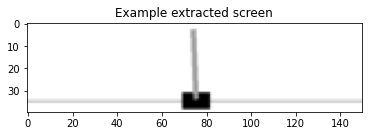

In [7]:
env.step(0)
plt.figure()
plt.imshow(env.get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy().squeeze(), cmap='gray')
plt.title('Example extracted screen')
plt.show()

In [8]:
screen_shape = env.get_screen().shape
policy_net = PolicyNetwork(h = screen_shape[2], w = screen_shape[3], device = device).to(device)

q_net = QNetwork(h = screen_shape[2], w = screen_shape[3], device = device).to(device)

policy_optimizer = optim.Adam(policy_net.parameters(), lr=POLICY_LR)
q_optimizer = optim.Adam(q_net.parameters(), lr = Q_LR)

q_mse_loss = nn.MSELoss()

In [9]:
p_screen = env.get_screen().to(device)
c_screen = env.get_screen().to(device)

x = torch.cat((p_screen, c_screen),dim=1)

print("Policy Network output:",policy_net(x))
print("Q Network output:", q_net(x))

Policy Network output: tensor([[0.5685, 0.4315]], device='cuda:3', grad_fn=<SoftmaxBackward>)
Q Network output: tensor([[-0.1057,  0.1801]], device='cuda:3', grad_fn=<AddmmBackward>)


In [10]:
def run_episode(episode, env, logger = None):
    policy_net.eval()
    q_net.eval()
    
    state = env.reset()
    prev_screen = env.get_screen().to(device)
    prev_x = None
    prev_y = None
    
    reward_sum = 0

    for steps in count():
        screen = env.get_screen().to(device)
        
        x = torch.cat((prev_screen, screen), dim=1)
        
        action_prob = policy_net(x)

        action = 0 if random.random() < action_prob[0][0] else 1

        y = torch.FloatTensor([[1, 0]] if action == 0 else [[0, 1]]).to(device)
        
        state, reward, done, _ = env.step(action)
        
        if prev_x is not None:
            q_loss = update_q(prev_x, prev_y, reward, x, q_net, policy_net, q_mse_loss, q_optimizer,done)
            policy_loss, entropy = update_policy(x, y, q_net, policy_net, policy_optimizer)
        
        reward_sum += reward
        prev_screen = screen
        prev_x = x
        prev_y = y
        
        if done or (steps == 1000):
            if logger != None:
                log.log_scalar(scalar=steps,episode=episode,name='duration')
                log.log_scalar(scalar=reward_sum,episode=episode,name='reward')
                log.log_scalar(scalar=entropy,episode=episode,name='entropy')
                log.log_scalar(scalar=q_loss,episode=episode,name='q_loss')
                log.log_scalar(scalar=policy_loss,episode=episode,name='policy_loss')
            print(f"[EPIPSODE] {episode} [STEP] {steps} [Q_LOSS] {q_loss} [POLICY LOSS] {policy_loss}")
            return False
                

def update_q(prev_state, prev_action, reward, state, q_net, policy_net, loss_function, optimizer,done):
    # q_net(s,a) = q_net(s,a) - lr * (reward + gamma * (q_net(s',a) @ policy_net(s')) - q_net(s,a))
    
    q_net.train()
    
    q_prev = q_net(prev_state)@prev_action.T
    q = q_net(state).detach()
    action_prob = policy_net(state).detach()
    #action_prob = torch.tensor([[0.5,0.5]],dtype=torch.float).to(device)
    
    if not done:
        loss = loss_function(q_prev,(reward + GAMMA*(q@action_prob.T)))
    else:
        loss = loss_function(q_prev,torch.tensor(reward,dtype=torch.float).to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

def update_policy(state, action, q_net, policy_net, optimizer):
    
    # policy_net = policy_net - lr * delta(log(policy_net) * (q_net(s,a) - q_net(s) @ policy_net(s)))
    
    policy_net.train()
    
    action_prob = policy_net(state)
    q = q_net(state).detach()
    
    q_policy = q@action_prob.detach().T
    q_actual = q@action.T
    adv = q_actual - q_policy
    
    log_action_prob = torch.log(action_prob)
    log_lik = action@log_action_prob.T
    log_lik_adv = log_lik * adv
    
    entropy = -log_action_prob@action_prob.T
    
    loss = -log_lik_adv - BETA*entropy
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), entropy.item()

In [11]:
#name = f"AC hidden=64 lr={LR} max_steps=1000 Adam fullwidth BETA={BETA}"
name = "AC test"
log = Logger(model_name=name)

In [ ]:
import time

for episode in count():
    complete = run_episode(episode, env,log)

    if complete:
        print('complete...!')
        break
    
    if episode % 50 == 0:
        clear_output(wait=True)
        torch.save(policy_net.state_dict(), f'models/{name}_policy.pt')
        torch.save(q_net.state_dict(), f'models/{name}_q.pt')

[EPIPSODE] 1451 [STEP] 25 [Q_LOSS] 0.06580735743045807 [POLICY LOSS] 0.0290910005569458
[EPIPSODE] 1452 [STEP] 13 [Q_LOSS] 7.386880874633789 [POLICY LOSS] -0.0013023706851527095
[EPIPSODE] 1453 [STEP] 12 [Q_LOSS] 0.3739892840385437 [POLICY LOSS] 0.006106272339820862
[EPIPSODE] 1454 [STEP] 8 [Q_LOSS] 0.00031930525437928736 [POLICY LOSS] 0.10075706988573074
[EPIPSODE] 1455 [STEP] 38 [Q_LOSS] 5.934669017791748 [POLICY LOSS] -0.013377890922129154
[EPIPSODE] 1456 [STEP] 10 [Q_LOSS] 4.834757328033447 [POLICY LOSS] -0.11192527413368225
[EPIPSODE] 1457 [STEP] 10 [Q_LOSS] 0.0012291150633245707 [POLICY LOSS] -0.044055696576833725
[EPIPSODE] 1458 [STEP] 8 [Q_LOSS] 9.073819160461426 [POLICY LOSS] -0.1927693486213684
[EPIPSODE] 1459 [STEP] 10 [Q_LOSS] 7.505154609680176 [POLICY LOSS] 0.10879123210906982
[EPIPSODE] 1460 [STEP] 14 [Q_LOSS] 0.07751429826021194 [POLICY LOSS] 0.0742802619934082
[EPIPSODE] 1461 [STEP] 21 [Q_LOSS] 2.236389398574829 [POLICY LOSS] -0.009362404234707355
[EPIPSODE] 1462 [STEP]

# 